## 本项目依赖的python包
```
pip install requests
pip install numpy
pip install pandas
pip install matplotlib
pip install pillow
pip install tensorflow
pip install keras
pip install git+git://github.com/keplr-io/quiver.git
```

## 从Kaggle下载数据并解压
运行此段代码前请登录Kaggle, 并且到页面https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules 点击同意比较规则。
下载数据时会提示输入用户名和密码。

In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1], force=True)
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1], force=True)            

Attempting to download data from : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip
Enter username:heirish
Enter password:········
Redirected: https://www.kaggle.com/account/login?ReturnUrl=%2fc%2fdogs-vs-cats-redux-kernels-edition%2fdownload%2ftrain.zip
Redirected: https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=competitions-data@kaggle-161607.iam.gserviceaccount.com&Expires=1505372446&Signature=K1WPGGEkhmYfP7pQsFHZZpC5YwdrUR7Ee0e1emXkQVPE%2FvEl6QyzfS5zOXBQ9CsfAQvQHh9h%2Bk9AsAYufBtFCZdSJQ2MFvK74UGSZQo%2FOo5uOYGNYroJ39hXLueun%2Bm%2BmDINZaMDdGZtI3cguTzGykg8lsMeR8MMpk5FqqmuwQ60KhFkjzEgL%2B058Mc%2BAdOWLvclM1KpQjIe6u8EYxuKOMl7dkLiBIjjhXYcIR8T1QJk4IVTMQrMM7mgrn7s19BSUm4Su%2BbOgpz%2Fym93NWIqu3Brsoc1H6kfdy5Jg5wTJzjora71Qb0Yjtd8Az470mZ9utHMU651G9jVknDqOcKFSQ%3D%3D
Status: 200

Download completed!
Found and verified. ./train.zip
Attempting to download data from : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-editio

In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


## 按模型输入要求重新分配数据目录
最终目录结构如下:
```
├─test
│  └─test
├─train
└─trainprocess
    ├─categorized
    │  ├─cat
    │  └─dog
    ├─train
    │  ├─cat
    │  └─dog
    └─valid
        ├─cat
        └─dog
```
其中:
* test是原始测试数据解压以后的目录，并添加了一层同名目录
* train是原始训练数据解压以后的目录
* trainprocess是对训练数据重新按"训练/分类","验证/分类"结构进行存放的目录。其中trianprocess/categorized是临时目录

In [3]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
#首次运行时请将此处的屏蔽打开
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\n'

## 探索数据
获取数据集样本数，图片尺寸分布图


dogs group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64

cats group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64


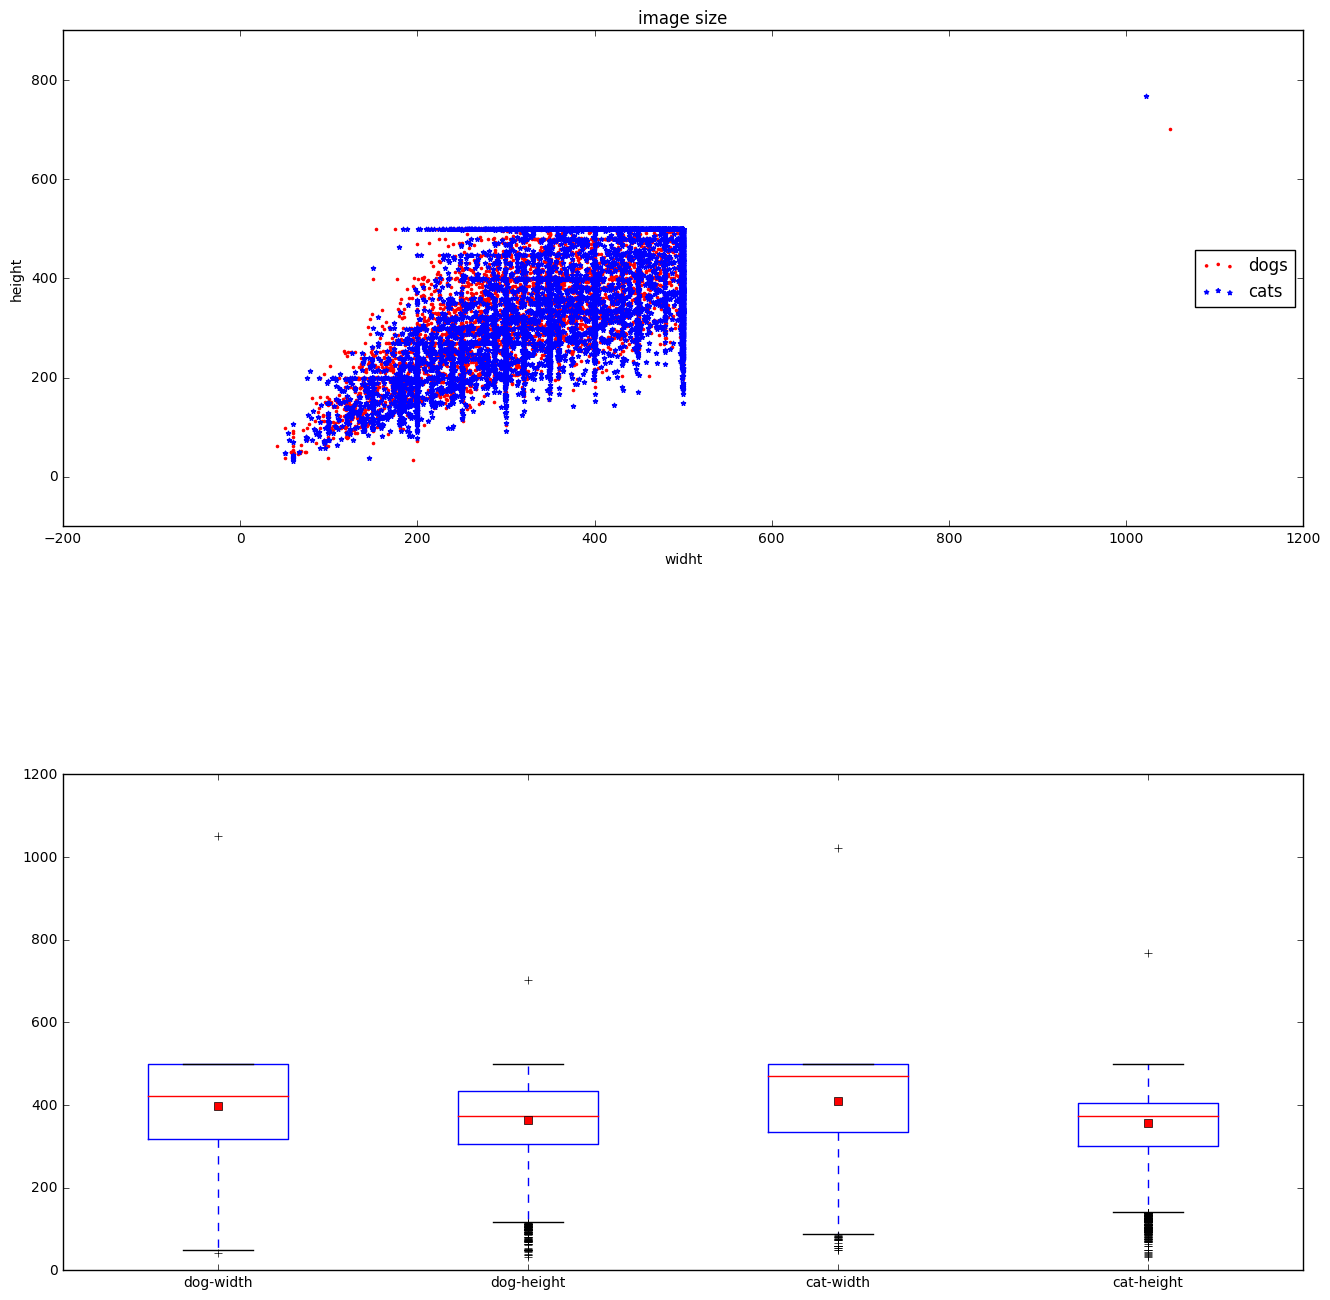


dogs width max/min:
               format mode width height
dog.2317.jpg    JPEG  RGB  1050    702
dog.10733.jpg   JPEG  RGB    42     62

dogs height max/min:
              format mode width height
dog.2317.jpg   JPEG  RGB  1050    702
dog.4367.jpg   JPEG  RGB   195     33

cats width max/mai:
               format mode width height
cat.835.jpg     JPEG  RGB  1023    768
cat.10392.jpg   JPEG  RGB    50     49

cats height max/min:
              format mode width height
cat.835.jpg    JPEG  RGB  1023    768
cat.6402.jpg   JPEG  RGB    60     32


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map

image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")

columns = ['format', 'mode', 'width', 'height']
df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())

plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

## 拆分训练集，验证集
将训练数据按比例拆分成训练集和验证集

In [4]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size

## 搭建卷积网络
按以下步骤进行:
* 搭建网络结构
* 选择优化器,loss函数
* 预处理训练数据(rescale, shear, zoom, flip)
* 为防止过拟合采用EarlyStopping(monitor='val_loss', patience=5), 在验证loss上如果5次迭代后还没有下降，则停止模型训练
* 使用ModelCheckpoint(file_bath, "val_loss", verbose=1, save_best_only=True)，存储在验证集上表现最好的模型状态。
* 训练完成后可视化训练过程，方便进行调参
* 最后存储模型结构及模型权重。方便以后时行预测或重现。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 145s - loss: 0.6451 - acc: 0.5995 - val_loss: 0.5913 - val_acc: 0.6849
Epoch 2/150
274/274 [==============================] - 148s - loss: 0.5436 - acc: 0.7243 - val_loss: 0.5204 - val_acc: 0.7340
Epoch 3/150
274/274 [==============================] - 144s - loss: 0.5074 - acc: 0.7512 - val_loss: 0.4820 - val_acc: 0.7720
Epoch 4/150
274/274 [==============================] - 149s - loss: 0.4734 - acc: 0.7737 - val_loss: 0.4316 - val_acc: 0.7979
Epoch 5/150
274/274 [==============================] - 148s - loss: 0.4448 - acc: 0.7949 - val_loss: 0.4272 - val_acc: 0.7972
Epoch 6/150
274/274 [==============================] - 130s - loss: 0.4138 - acc: 0.8141 - val_loss: 0.4535 - val_acc: 0.7876
Epoch 7/150
274/274 [==============================] - 151s - loss: 0.3851 - acc: 0.8258 - val_loss: 0.3915 - val_acc: 0.8260
Epoch 8/150
274/274 [============

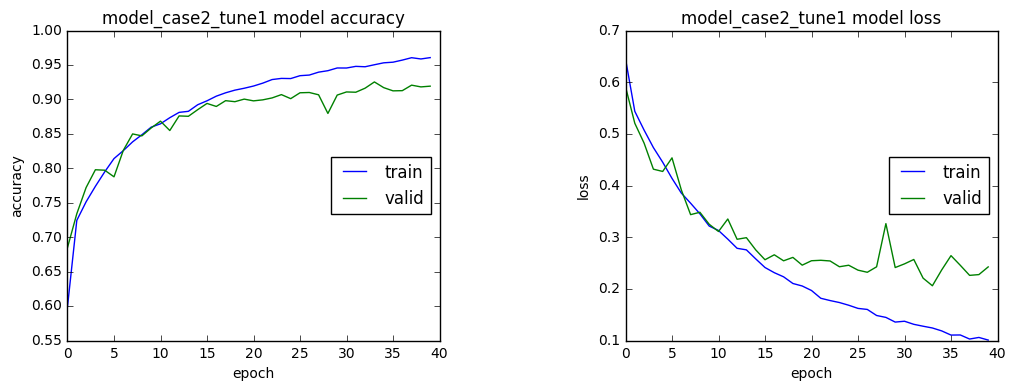

NameError: name 'history_vgg16_pre_tune2' is not defined

In [13]:
#model_case2_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)
total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size

image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150

name_case2_tune1 = "model_case2_tune1"
model_case2_tune1 = ModelUtil.model_mycase2_tune1(image_width, image_height)
adam = optimizers.Adam(lr=0.0001)
rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune1, model_name=name_case2_tune1)
history_case2_tune1 = ModelUtil.train_data_earlystopping(model_case2_tune1, model_name=name_case2_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune1, model_name=name_case2_tune1)
with open(name_case2_tune1+'.pickle', 'wb') as f:
    pickle.dump(history_case2_tune1.history, f)
ModelUtil.save_model(model_case2_tune1, model_name=name_case2_tune1)

In [10]:
model_case2_tune1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_cov1 (Conv2D)         (None, 224, 224, 16)      448       
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 112, 112, 16)      0         
_________________________________________________________________
block2_cov1 (Conv2D)         (None, 112, 112, 32)      4640      
_________________________________________________________________
block2_pool1 (MaxPooling2D)  (None, 56, 56, 32)        0         
_________________________________________________________________
block3_cov1 (Conv2D)         (None, 56, 56, 64)        18496     
_________________________________________________________________
block3_pool1 (MaxPooling2D)  (None, 28, 28, 64)        0         
_________________________________________________________________
block4_cov1 (Conv2D)         (None, 28, 28, 128)       73856     
__________

经过一调参以及加上dropout之后，可见模型的训练loss能达到0.1243, 验证loss能达到0.20596, 有点过拟合。后面将搭建一个VGG16网络，重新训练。

1.然后搭建一个VGG16卷积网络，卷积块同VGG16一样，修改全连接层，从头训练所有的权重，最后输出层以sigmoid激活。使用binary_crossentropy作为loss评估。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 939s - loss: 0.7134 - acc: 0.5351 - val_loss: 0.6745 - val_acc: 0.5811
Epoch 2/150
274/274 [==============================] - 938s - loss: 0.6335 - acc: 0.6398 - val_loss: 0.5803 - val_acc: 0.6869
Epoch 3/150
274/274 [==============================] - 940s - loss: 0.5794 - acc: 0.6946 - val_loss: 0.5225 - val_acc: 0.7344
Epoch 4/150
274/274 [==============================] - 933s - loss: 0.5327 - acc: 0.7378 - val_loss: 0.5021 - val_acc: 0.7532
Epoch 5/150
274/274 [==============================] - 941s - loss: 0.4526 - acc: 0.7918 - val_loss: 0.3842 - val_acc: 0.8219
Epoch 6/150
274/274 [==============================] - 886s - loss: 0.3856 - acc: 0.8262 - val_loss: 0.3900 - val_acc: 0.8524
Epoch 7/150
274/274 [==============================] - 946s - loss: 0.3364 - acc: 0.8546 - val_loss: 0.2854 - val_acc: 0.8769
Epoch 8/150
274/274 [============

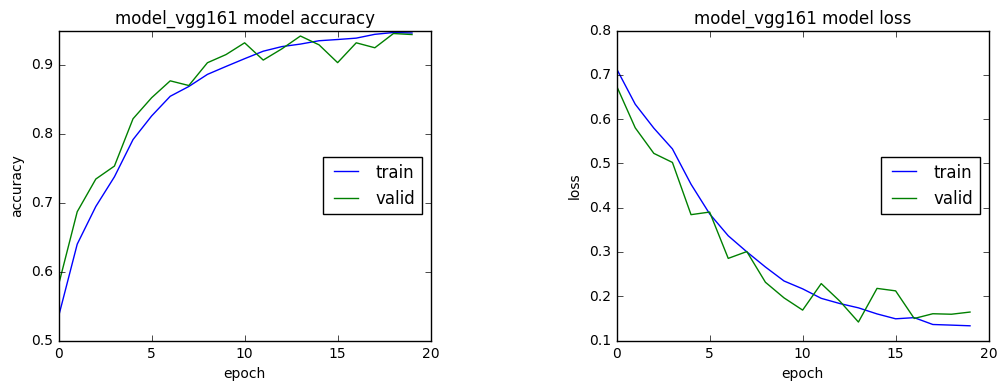

In [10]:
#model_vgg161
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg161 = "model_vgg161"
model_vgg161 = ModelUtil.model_vgg161(image_width, image_height)
adam = optimizers.Adam(lr=0.0001)
rmsp = optimizers.RMSprop(lr=0.0001)
model_vgg161.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg161, model_name=name_vgg161)
history_vgg161 = ModelUtil.train_data_earlystopping(model_vgg161, model_name=name_vgg161, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg161, model_name=name_vgg161)
with open(name_vgg161 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg161.history, f)
ModelUtil.save_model(model_vgg161, model_name=name_vgg161)

In [11]:
model_vgg161.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

采用VGG16卷积结构能达到的效果，训练集loss为0.1737， 验证集为0.1417。可见增大模型capacity能在一定程度上提升模型效果。
由于从头搭建的模型需要重新计算每一层的权重,而卷积神经网络的权重又很多，以上面搭建的为例，每一次迭代需要计算并更新27,626,049个权重,由于时间以及硬件资源的限制，后面将采用ImageNet己经预训练好的模型进行迁移学习，tensorflow目前提供VGG16， VGG19, ResNet, Xception,Inception等几种接口。这些预训练模型己经在更大规模的数据上训练过，且分类数也更多，达到1000个分类。通过直接加载预训练好的模型结构及其权重，针对本项目中的二分类问题进行输出块的改进。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 381s - loss: 0.3213 - acc: 0.8533 - val_loss: 0.1892 - val_acc: 0.9223
Epoch 2/150
274/274 [==============================] - 405s - loss: 0.2338 - acc: 0.9007 - val_loss: 0.1634 - val_acc: 0.9344
Epoch 3/150
274/274 [==============================] - 350s - loss: 0.2047 - acc: 0.9120 - val_loss: 0.1638 - val_acc: 0.9356
Epoch 4/150
274/274 [==============================] - 409s - loss: 0.1998 - acc: 0.9155 - val_loss: 0.1625 - val_acc: 0.9332
Epoch 5/150
274/274 [==============================] - 401s - loss: 0.1873 - acc: 0.9206 - val_loss: 0.1471 - val_acc: 0.9400
Epoch 6/150
274/274 [==============================] - 350s - loss: 0.1770 - acc: 0.9269 - val_loss: 0.1682 - val_acc: 0.9327
Epoch 7/150
274/274 [==============================] - 351s - loss: 0.1686 - acc: 0.9300 - val_loss: 0.1658 - val_acc: 0.9307
Epoch 8/150
274/274 [============

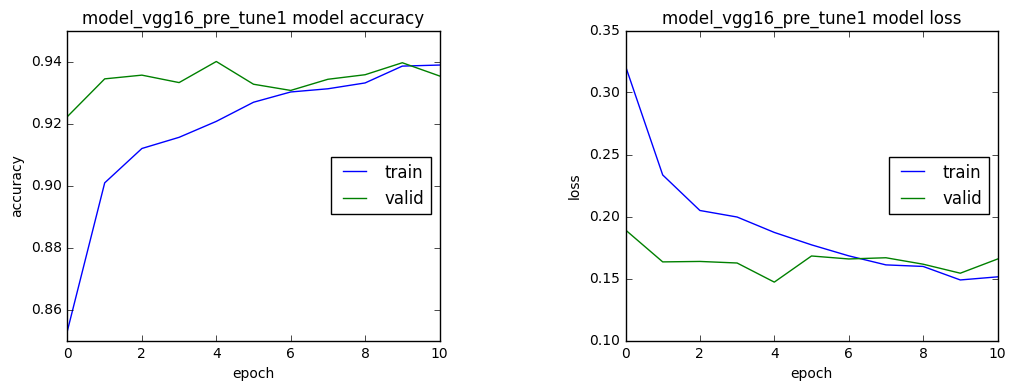

In [5]:
#model_vgg16_pre_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune1 = "model_vgg16_pre_tune1"
model_vgg16_pre_tune1 = ModelUtil.model_vgg16_pre_tune1(image_width, image_height)
sgd = optimizers.SGD(lr=0.0001)
adam = optimizers.Adam(lr=0.0001)
model_vgg16_pre_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
history_vgg16_pre_tune1 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
with open(name_vgg16_pre_tune1 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune1.history, f)
ModelUtil.save_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)

In [12]:
model_vgg16_pre_tune1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

可见只训练flat层的效果与从头训练的效果差不多，最终在训练集上的loss为0.1873, 在验证集上的loss为0.1471,但是单次epoch的训练时间更少。

3.后面加的卷积层过多，对模型的训练可能起到反作用。不管如何迭代，由于网络层数太大，导致梯度消失，相当于前面部分的网络没有为特征提取起作用，而且也导致了后面部分的网络的无效,在训练过程中有可能导致卷积层的特征被训练没了，即网络退化现象。加深网络会带来如下三大类问题：1. 后向传播梯度消失；2. 前向传播信息量减少；3. 训练时间加长。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 345s - loss: 0.3930 - acc: 0.8218 - val_loss: 0.2433 - val_acc: 0.8972
Epoch 2/150
274/274 [==============================] - 343s - loss: 0.2449 - acc: 0.8961 - val_loss: 0.2007 - val_acc: 0.9172
Epoch 3/150
274/274 [==============================] - 335s - loss: 0.2234 - acc: 0.9057 - val_loss: 0.2018 - val_acc: 0.9205
Epoch 4/150
274/274 [==============================] - 343s - loss: 0.2089 - acc: 0.9124 - val_loss: 0.1839 - val_acc: 0.9220
Epoch 5/150
274/274 [==============================] - 335s - loss: 0.2054 - acc: 0.9138 - val_loss: 0.2054 - val_acc: 0.9185
Epoch 6/150
274/274 [==============================] - 335s - loss: 0.2059 - acc: 0.9142 - val_loss: 0.1963 - val_acc: 0.9204
Epoch 7/150
274/274 [==============================] - 335s - loss: 0.1913 - acc: 0.9198 - val_loss: 0.1903 - val_acc: 0.9231
Epoch 8/150
274/274 [============

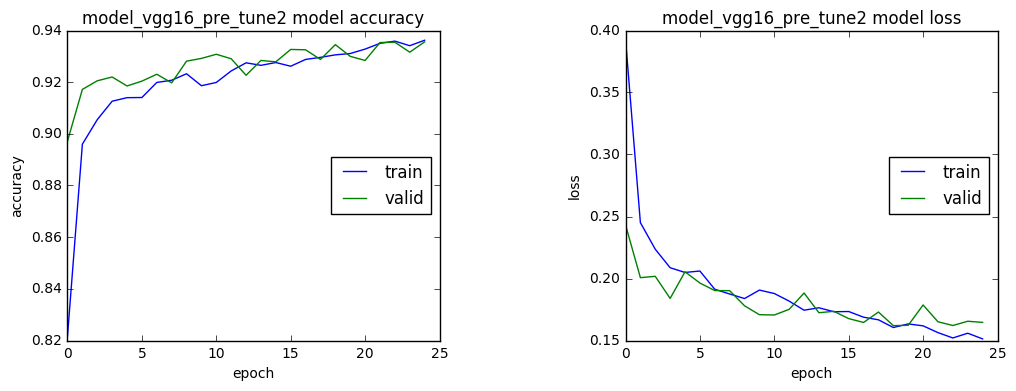

In [5]:
#model_vgg16_pre_tune2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune2 = "model_vgg16_pre_tune2"
model_vgg16_pre_tune2 = ModelUtil.model_vgg16_pre_tune2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
adam = optimizers.Adam(lr=1e-4)
model_vgg16_pre_tune2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
history_vgg16_pre_tune2 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
with open(name_vgg16_pre_tune2 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune2.history, f)
ModelUtil.save_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)

In [13]:
model_vgg16_pre_tune2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

综合上面的结果，对VGG16的迁移学习能达到的最好效果在测试集上的loss为0.15左右，离benchmark的目标还差得较远，考虑到模型本身的局限，下面采取更换模型的策略，针对ResNet进行迁移学习。

choosed:换ResNet进行训练，发现要比VGG16效果好很多，虽然ResNet网络层数比VGG16多，但是训练速度却更快。因为ResNet网络结构，以及权重数2049,
加上ResNet的结构说明。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 278s - loss: 0.3969 - acc: 0.8429 - val_loss: 0.7167 - val_acc: 0.5007
Epoch 2/150
274/274 [==============================] - 261s - loss: 0.1992 - acc: 0.9418 - val_loss: 0.7131 - val_acc: 0.5612
Epoch 3/150
274/274 [==============================] - 262s - loss: 0.1527 - acc: 0.9543 - val_loss: 0.2309 - val_acc: 0.9065
Epoch 4/150
274/274 [==============================] - 261s - loss: 0.1294 - acc: 0.9593 - val_loss: 0.0986 - val_acc: 0.9677
Epoch 5/150
274/274 [==============================] - 262s - loss: 0.1170 - acc: 0.9613 - val_loss: 0.0890 - val_acc: 0.9736
Epoch 6/150
274/274 [==============================] - 260s - loss: 0.1073 - acc: 0.9641 - val_loss: 0.0810 - val_acc: 0.9732
Epoch 7/150
274/274 [==============================] - 262s - loss: 0.1041 - acc: 0.9644 - val_loss: 0.0797 - val_acc: 0.9757
Epoch 8/150
274/274 [============

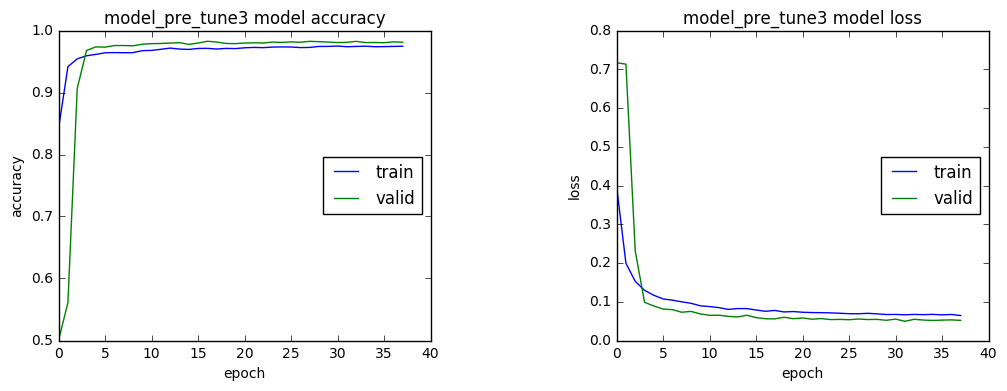

Found 18 images belonging to 1 classes.
0 test/cat.21.jpg [  8.86895068e-05]
1 test/dog.51.jpg [ 0.9999938]
2 test/dog.71.jpg [ 0.96869534]
3 test/dog.91.jpg [ 0.98898149]
4 test/cat.41.jpg [  9.61874030e-05]
5 test/cat.11.jpg [ 0.0004966]
6 test/dog.41.jpg [ 0.99945003]
7 test/cat.91.jpg [ 0.00012532]
8 test/dog.11.jpg [ 0.99996543]
9 test/cat.71.jpg [ 0.00790725]
10 test/cat.51.jpg [ 0.0001474]
11 test/dog.61.jpg [ 0.99774867]
12 test/cat.31.jpg [ 0.00012377]
13 test/dog.81.jpg [ 0.9930321]
14 test/cat.81.jpg [  1.56735825e-06]
15 test/cat.61.jpg [ 0.00057463]
16 test/dog.21.jpg [ 0.99975044]
17 test/dog.31.jpg [ 0.98894042]


In [ ]:
#model_pre_tune3

import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500
total_valid_size = 7500 
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_pre_tune3 = "model_pre_tune3"
model_pre_tune3 = ModelUtil.model_pre_tune3(image_width, image_height)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9)
adam = optimizers.Adam(lr=1e-4)
model_pre_tune3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_pre_tune3, model_name=name_pre_tune3)
history_pre_tune3 = ModelUtil.train_data_earlystopping(model_pre_tune3, model_name=name_pre_tune3, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
with open(name_pre_tune3 + '.pickle', 'wb') as f:
    pickle.dump(history_pre_tune3.history, f)
ModelUtil.visualize_history(history_pre_tune3, model_name=name_pre_tune3)

ModelUtil.predict_small_data(model_pre_tune3, "./visual_images", image_width, image_height, perbatch)
ModelUtil.save_model(model_pre_tune3, model_name=name_pre_tune3)

In [7]:
model_pre_tune3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 280s - loss: 0.1742 - acc: 0.9298 - val_loss: 0.7407 - val_acc: 0.4353
Epoch 2/150
274/274 [==============================] - 265s - loss: 0.0999 - acc: 0.9619 - val_loss: 0.7417 - val_acc: 0.5651
Epoch 3/150
274/274 [==============================] - 300s - loss: 0.0909 - acc: 0.9645 - val_loss: 0.3133 - val_acc: 0.8811
Epoch 4/150
274/274 [==============================] - 295s - loss: 0.0832 - acc: 0.9674 - val_loss: 0.0575 - val_acc: 0.9787
Epoch 5/150
274/274 [==============================] - 291s - loss: 0.0740 - acc: 0.9711 - val_loss: 0.0561 - val_acc: 0.9785
Epoch 6/150
274/274 [==============================] - 298s - loss: 0.0695 - acc: 0.9730 - val_loss: 0.0530 - val_acc: 0.9784
Epoch 7/150
274/274 [==============================] - 298s - loss: 0.0666 - acc: 0.9735 - val_loss: 0.0461 - val_acc: 0.9809
Epoch 8/150
274/274 [============

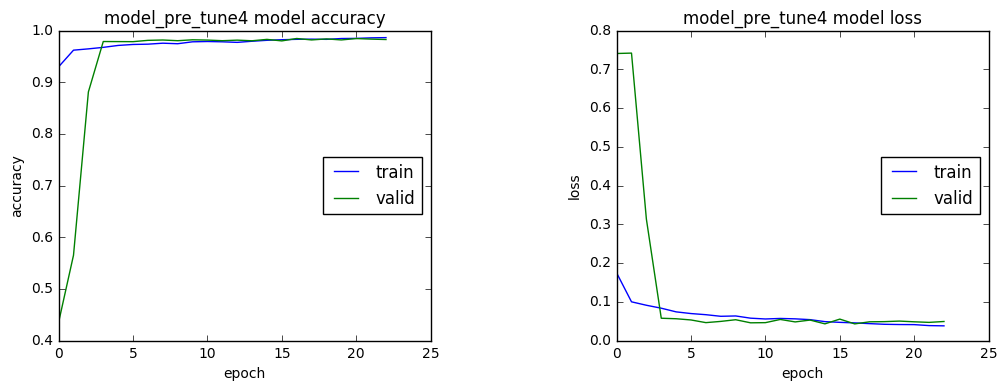

Found 18 images belonging to 1 classes.
0 test/cat.21.jpg [  7.02242930e-09]
1 test/dog.51.jpg [ 1.]
2 test/dog.71.jpg [ 0.99786085]
3 test/dog.91.jpg [ 0.99996233]
4 test/cat.41.jpg [  2.21069705e-08]
5 test/cat.11.jpg [  1.85936770e-07]
6 test/dog.41.jpg [ 0.99997807]
7 test/cat.91.jpg [  3.10364605e-08]
8 test/dog.11.jpg [ 1.]
9 test/cat.71.jpg [  5.59437867e-05]
10 test/cat.51.jpg [  8.96609365e-09]
11 test/dog.61.jpg [ 0.99999332]
12 test/cat.31.jpg [  5.63472469e-08]
13 test/dog.81.jpg [ 0.9998616]
14 test/cat.81.jpg [  1.46789261e-10]
15 test/cat.61.jpg [  1.18143578e-06]
16 test/dog.21.jpg [ 0.99999976]
17 test/dog.31.jpg [ 0.99991369]


In [8]:
#model_pre_tune4

import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500
total_valid_size = 7500 
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_pre_tune4 = "model_pre_tune4"
model_pre_tune4 = ModelUtil.model_pre_tune4(image_width, image_height)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9)
adam = optimizers.Adam(lr=1e-4)
model_pre_tune4.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_pre_tune4, model_name=name_pre_tune4)
history_pre_tune4 = ModelUtil.train_data_earlystopping(model_pre_tune4, model_name=name_pre_tune4, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
with open(name_pre_tune4 + '.pickle', 'wb') as f:
    pickle.dump(history_pre_tune4.history, f)
ModelUtil.visualize_history(history_pre_tune4, model_name=name_pre_tune4)

ModelUtil.predict_small_data(model_pre_tune4, "./visual_images", image_width, image_height, perbatch)
ModelUtil.save_model(model_pre_tune4, model_name=name_pre_tune4)

In [9]:
model_pre_tune4.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 230, 230, 3)   0           input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

在测试数据上预测模型, 进行结果上传至Kaggle评分。

In [16]:
from keras.models import model_from_json
import ModelUtil
import importlib
importlib.reload(ModelUtil)

image_width = 224
image_height = 224
perbatch = 16

chosed_model_name="model_pre_tune3"
chosed_model = model_from_json(open(chosed_model_name + '.json').read())
chosed_model.load_weights(chosed_model_name + '_top.h5')

ModelUtil.predict_data(chosed_model, model_name=chosed_model_name, 
                image_size=(image_width, image_height), 
                num_perbatch=perbatch)

Found 12500 images belonging to 1 classes.


In [14]:
from keras.models import model_from_json
import ModelUtil
import importlib
importlib.reload(ModelUtil)

image_width = 224
image_height = 224
perbatch = 16

chosed_model_name="model_pre_tune4"
chosed_model = model_from_json(open(chosed_model_name + '.json').read())
chosed_model.load_weights(chosed_model_name + '_top.h5')

ModelUtil.predict_data(chosed_model, model_name=chosed_model_name, 
                image_size=(image_width, image_height), 
                num_perbatch=perbatch)

Found 12500 images belonging to 1 classes.


可视化ResNet卷积层

In [ ]:
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import ModelUtil
import importlib
importlib.reload(ModelUtil)
#由于本项目中对图片进行了scale处理，因此要修改quiver_engin源代码
#进入quiver_engin安装目录，例如${ANACONDA_PATH}\Lib\site-packages\quiver_engine-0.1.4.1.5-py3.5.egg\quiver_engine
#替换server.py中所有的load_img为load_img_scaled
from quiver_engine import server
from keras import applications

image_width = 224
image_height = 224
perbatch = 64

model_name="model_pre_tune4"
model = model_from_json(open(model_name + '.json').read())
model.load_weights(model_name + '_top.h5')

server.launch(model,  classes=['dog'], input_folder="./visual_images/test", port=7000)

Starting webserver from: d:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\quiver_engine-0.1.4.1.5-py3.5.egg\quiver_engine


::1 - - [2017-09-17 15:44:04] "GET /inputs HTTP/1.1" 200 765 0.001000
::1 - - [2017-09-17 15:44:04] "GET /model HTTP/1.1" 200 159416 0.037004
::1 - - [2017-09-17 15:44:05] "GET /input-file/10230.jpg HTTP/1.1" 200 14658 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/120.jpg HTTP/1.1" 200 15874 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/11161.jpg HTTP/1.1" 200 8863 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/11105.jpg HTTP/1.1" 200 13616 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/4705.jpg HTTP/1.1" 200 44423 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/12099.jpg HTTP/1.1" 200 3825 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/4875.jpg HTTP/1.1" 200 7430 0.002000
::1 - - [2017-09-17 15:44:05] "GET /input-file/4748.jpg HTTP/1.1" 200 3217 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/5313.jpg HTTP/1.1" 200 2355 0.001000
::1 - - [2017-09-17 15:44:05] "GET /input-file/5326.jpg HTTP/1.1" 200 20748 0.001000
::1 - - [2